In [10]:
import os
from pprint import pprint
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]

In [3]:
data_dir = '../logs/VizDoom/'
data_files = os.listdir(data_dir)
data = list()
labels = list()

fmt = '{:<20}{}'

for i, file in enumerate(data_files):
    if 'eval' not in file and ('online_trial' in file or file.startswith('dqn')):
        with open(data_dir + file, 'r') as f:
            data.append(f.readlines()[1:])
        if 'dqn' in file:
            lab = 'dqn' + file.split('-')[-1].split('.')[0]
        else:
            lab = 'wm ' + file.split('_')[-1].split('.')[0]
        labels.append(lab)
print('Lines per dataset:')
for i in range(len(data)):
    print(fmt.format(labels[i], len(data[i])))

Lines per dataset:
dqn1                68784
wm 2                132948
wm 4                111744
dqn3                67884
wm 1                58014
wm 0                68388
dqn0                134718
wm 3                142230
dqn4                216336
dqn2                62046


In [4]:
def chunk(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

chunked_data = list()

print('Episodes per dataset:')
for i, ds in enumerate(data):
    if 'random' in labels[i].lower():
        chunk_size = 5
    else:
        chunk_size = 6
    chunked_data.append(list(chunk(ds, chunk_size)))
    
    print(fmt.format(labels[i], len(chunked_data[i])))

Episodes per dataset:
dqn1                11464
wm 2                22158
wm 4                18624
dqn3                11314
wm 1                9669
wm 0                11398
dqn0                22453
wm 3                23705
dqn4                36056
dqn2                10341


In [5]:
episode_rewards = dict()

for i, chunked_ds in enumerate(chunked_data):   
    episode_rew = [float(epi[1].strip().split(': ')[1]) for epi in chunked_ds]
    episode_rewards[labels[i]] = episode_rew

In [6]:
avg_rewards = dict()

for i, chunked_ds in enumerate(chunked_data):   
    avg_rew = [float(epi[3].strip().split(': ')[1]) for epi in chunked_ds]
    avg_rewards[labels[i]] = avg_rew

In [28]:
avg_rewards = dict()

conv_rate = 0.01

for i, chunked_ds in enumerate(chunked_data):    
    last = list()
    conv_count = 0
    conv_place = 0
    for j, epi in enumerate(chunked_ds):
        if abs(float(epi[4].strip().split(': ')[1])) < conv_rate and j > 5000:
            last.append(epi[4].strip().split(': ')[1])
            conv_count += 1
        else:
            last = list()
            conv_count = 0
            
        if conv_count == 5:
            conv_place = j
            break
            
    if conv_place == 0:
        conv_place = j
    
    avg_rew = [float(epi[3].strip().split(': ')[1]) for epi in chunked_ds]        
    avg_rewards[labels[i]] = avg_rew[:conv_place-1]

(0, 10736)

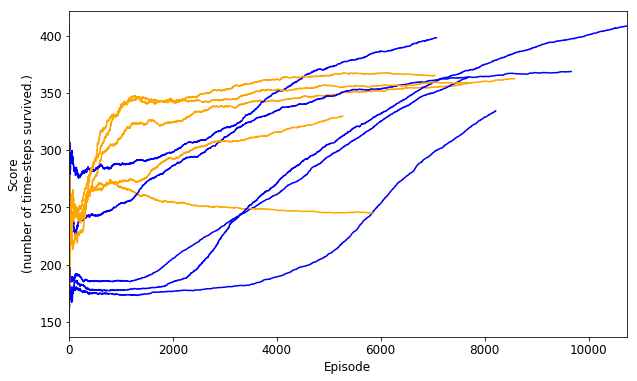

In [29]:
from copy import deepcopy
def pad(dataset, length):
    ds = deepcopy(dataset)
    while len(ds) < length:
        ds.append(ds[-1])
    
    return ds

limit = np.max([len(avg_rewards[label]) for label in labels])

lower_bound = 150
upper_bound = float('INF')

for label, dataset in zip(labels, avg_rewards.values()):
    if 'wm' in label:
        color = 'blue'
    else:
        color = 'orange'
    
    clip = np.clip(dataset[:limit], lower_bound, upper_bound)
    plt.plot(clip, label=label, color=color)
    placement = limit if len(dataset) > limit else len(dataset)-1
#     plt.annotate(f'{label.title()} - {dataset[placement]:.3f}',
#                  (placement, dataset[placement]),
#                  textcoords='offset points', xytext=(7.5,0),
#                  ha='left', color=color)
    
    
plt.xlabel("Episode")
plt.ylabel("Score\n(number of time-steps survived.)")
plt.xlim((0,limit))

# Put a legend below current axis
# plt.legend()

In [30]:
limit = np.max([len(avg_rewards[label]) for label in labels])

lower_bound = 150
upper_bound = float('INF')

def get_spread(dataset):

    mean = list()
    dev = list()
    lwr_dev = list()
    upr_dev = list()

    padded_datasets = [pad(ds, limit) for ds in dataset]  
    
    for points in zip(*padded_datasets):
        mn = np.mean(points)
        dv = np.std(points)

        mean.append(mn)
        dev.append(dv)
        lwr_dev.append(mn-dv)
        upr_dev.append(mn+dv)
        
    return mean, dev, lwr_dev, upr_dev

dqn_set = [points for (label, points) in avg_rewards.items() if 'dqn' in label and '3' not in label]   
wm_set = [points for (label, points) in avg_rewards.items() if 'wm' in label]   
    
dqn_mean, dqn_dev, dqn_lwr_dev, dqn_upr_dev = get_spread(dqn_set)    
wm_mean, wm_dev, wm_lwr_dev, wm_upr_dev = get_spread(wm_set)
    
print(f'DQN\n{"-"*25}')
print(f'Mean deviation: {np.mean(dqn_dev):0.4f}')
print(f'Avg deviation: {np.mean(dqn_dev):0.4f}')
print(f'Max deviation: {np.max(dqn_dev):0.4f}')
print(f'Min deviation: {np.min(dqn_dev[1:]):0.4f}')
print(f'Final deviation: {dqn_dev[-1]:0.4f}')
  
print(f'\nWM\n{"-"*25}')
print(f'Mean deviation: {np.mean(wm_dev):0.4f}')
print(f'Avg deviation: {np.mean(wm_dev):0.4f}')
print(f'Max deviation: {np.max(wm_dev):0.4f}')
print(f'Min deviation: {np.min(wm_dev[1:]):0.4f}')
print(f'Final deviation: {wm_dev[-1]:0.4f}')

DQN
-------------------------
Mean deviation: 16.0665
Avg deviation: 16.0665
Max deviation: 108.3340
Min deviation: 3.5583
Final deviation: 14.3051

WM
-------------------------
Mean deviation: 40.6443
Avg deviation: 40.6443
Max deviation: 66.4405
Min deviation: 20.8539
Final deviation: 26.3556


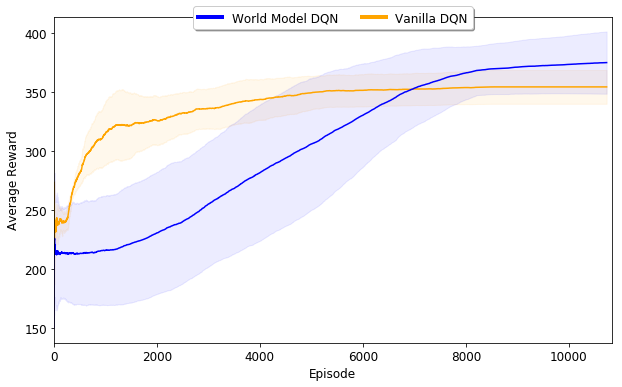

In [31]:
font = {'family' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

# limit=25000

clip_wm_mean = np.clip(pad(wm_mean, limit), lower_bound, upper_bound)
clip_wm_upr_dev = np.clip(pad(wm_upr_dev, limit), lower_bound, upper_bound)
clip_wm_lwr_dev = np.clip(pad(wm_lwr_dev, limit), lower_bound, upper_bound)

clip_dqn_mean = np.clip(pad(dqn_mean, limit), lower_bound, upper_bound)
clip_dqn_upr_dev = np.clip(pad(dqn_upr_dev, limit), lower_bound, upper_bound)
clip_dqn_lwr_dev = np.clip(pad(dqn_lwr_dev, limit), lower_bound, upper_bound)

fig, ax = plt.subplots()
x = np.linspace(0, limit-1, limit)

ax.plot(x, clip_dqn_mean, color='orange', label='DQN')
ax.fill_between(x, clip_dqn_upr_dev, clip_dqn_lwr_dev, color='orange', alpha=0.075)

ax.plot(x, clip_wm_mean, color='blue', label='World Models')
ax.fill_between(x, clip_wm_upr_dev, clip_wm_lwr_dev, color='blue', alpha=0.075)

plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.xlim((0,limit+100))

# Put a legend below current axis
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='orange', lw=4),]
plt.legend(custom_lines, ['World Model DQN', 'Vanilla DQN'], loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)